# Reddit: r/TheOnion vs. r/nottheonion
> Author: [Dawn Graham](https://dawngraham.github.io/)

## 02. NLP & Classification Modeling

### Problem Statement

While "fake news" has become a hot topic in recent years, fake news is nothing new. It's also not new that truth is often stranger than fiction - sometimes real stories are hard to believe.
 
Researcher Claire Wardle categorized fake news into seven types:<sup>1</sup>
![7 Types of Mis- and Disinformation](../images/FDN_7Types_Misinfo-01-1024x576.jpg)

*The Onion* falls into the first type: satire or parody. The organization started publishing satirical news articles in print in 1988, then went online in 1996.<sup>2</sup> Articles from *The Onion* and its satirical sister sites are shared on the Reddit subreddit <a href="https://www.reddit.com/r/TheOnion" target="_blank">r/TheOnion</a>, which has 83.1k subscribers as of December 21, 2018.

There is also the subreddit <a href="https://www.reddit.com/r/nottheonion" target="_blank">r/nottheonion</a>: "For true stories that are so mind-blowingly ridiculous that you could have sworn they were from The Onion." This currently has 14.5m subscribers, far outnumbering the subreddit for the publication it references.

Another subreddit <a href="https://www.reddit.com/r/AteTheOnion" target="_blank">r/AteTheOnion</a> has 229k subscribers, also outnumbering subscribers to r/TheOnion. This one is dedicated to "screencaps of people who failed to see The Onion's articles as satire."  

r/nottheonion and r/AteTheOnion point both to the interest in "strange but true" news and the challenge of separating fact from fiction.  

This raises the question: **Can we predict whether an article is from r/TheOnion (fake news) or from r/nottheonion (real news) by the title alone?**


---
#### References
1. Wardle, Claire (16 February 2017). <a href="https://firstdraftnews.org/fake-news-complicated/" target="_blank">"Fake news. It’s complicated."</a> *First Draft.* Retrieved 21 December 2018.
2. Wikipedia contributors (19 December 2018). <a href="https://en.wikipedia.org/wiki/The_Onion" target="_blank">The Onion</a>. *Wikipedia, The Free Encyclopedia.*  Retrieved 21 December 2018.

### Import Libraries

In [1]:
# General
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# For Natural Language Processing
import regex as re
import unidecode
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

# For classification modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# For evaluation
from sklearn.metrics import confusion_matrix

# For wordclouds
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

### Set up dataframe

In [2]:
# Read in both subreddit datasets
df_theonion = pd.read_csv('../data/TheOnion_181217_184244.csv')
df_nottheonion = pd.read_csv('../data/nottheonion_181217_184009.csv')

# Combine into single dataframe
df = pd.concat([df_theonion, df_nottheonion])
df = df.reset_index(drop=True)
df['is_onion'] = df['subreddit'].map(lambda t: 1 if t == 'TheOnion' else 0)

### EDA

#### Initial Checks

In [3]:
df.head(3)

,created_utc,url,id,num_comments,title,subreddit,timestamp,is_onion
0,1545089481,https://www.reddit.com/r/TheOnion/comments/a75...,a75a2d,0,Maria Butina Pleads Guilty To Russian Scheme T...,TheOnion,2018-12-17 18:31:21,1
1,1545083658,https://www.reddit.com/r/TheOnion/comments/a74...,a74ecp,0,Drew Brees said WHAT?!,TheOnion,2018-12-17 16:54:18,1
2,1545082273,https://www.reddit.com/r/TheOnion/comments/a74...,a746b4,0,Ryan Zinke Apologizes For Misuse Of Government...,TheOnion,2018-12-17 16:31:13,1


In [4]:
df.shape

(20000, 8)

In [5]:
df.dtypes

created_utc      int64
url             object
id              object
num_comments     int64
title           object
subreddit       object
timestamp       object
is_onion         int64
dtype: object

In [6]:
# Check for null values
df.isnull().sum()

created_utc     0
url             0
id              0
num_comments    0
title           0
subreddit       0
timestamp       0
is_onion        0
dtype: int64

In [7]:
df.describe()

,created_utc,num_comments,is_onion
count,2.000000e+04,20000.00000,20000.000000
mean,1.528816e+09,9.99345,0.500000
std,2.036570e+07,108.57496,0.500013
min,1.474585e+09,0.00000,0.000000
25%,1.519100e+09,0.00000,0.000000
50%,1.541087e+09,1.00000,0.500000
75%,1.543232e+09,2.00000,1.000000
max,1.545090e+09,5158.00000,1.000000


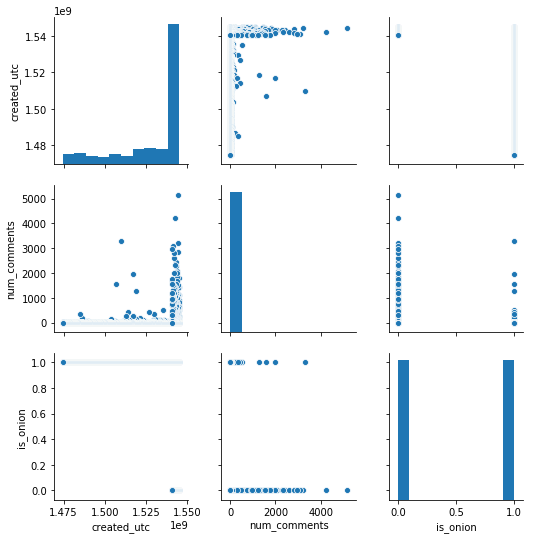

In [8]:
sns.pairplot(df);

In [9]:
# Confirm these values are as expected
df['is_onion'].value_counts()

1    10000
0    10000
Name: is_onion, dtype: int64

This data was collected on December 17, 2018. It contains the 10,000 most recent submissions (at time of collection) to each subreddit, r/TheOnion and r/nottheonion.  

Submissions to r/TheOnion span from September 22, 2016 to December 17, 2018.  
Submissions to r/nottheonion span from October 26, 2018 to December 17, 2018.  

The shorter time span for r/nottheonion reflects both the larger subscriber base and the greater diversity of sources. People can submit news articles from any "original, reliable source" written in English, whereas r/TheOnion only accepts articles from *The Onion* or sister sites.<sup>3</sup>

---
3. <a href="https://www.reddit.com/r/nottheonion/wiki/nto101" target="_blank">"Welcome to NTO101: An Introduction to /r/NotTheOnion!"</a> *Reddit.* Retrieved 21 December 2018.

#### See examples of titles from each class

In [10]:
# Titles from TheOnion
df.loc[df['is_onion'] == 1, 'title'].head(15)

0     Maria Butina Pleads Guilty To Russian Scheme T...
1                                Drew Brees said WHAT?!
2     Ryan Zinke Apologizes For Misuse Of Government...
3                                    Report: Re-mixxxx!
4     Trump Administration Launches Human Rights Inv...
5                       Everything Reminds Man Of ‘Her’
6     Legal Bombshell: Mueller Flipped Trump’s Confi...
7     ‘Sesame Street’ Includes First Muppet To Exper...
8     Woman Who Hasn’t Bought Anything Recently Wond...
9     Holy Fucking Shit: Fargas The Foreign-Exchange...
10    Humanity Surprised It Still Hasn’t Figured Out...
11        Congress Cuts Funding For 26-Year-Old Stepson
12    New Aetna Wedding Registry Lets Guests Purchas...
13     The Week In Pictures – Week Of December 17, 2018
14    i am planing on making a The Onion reporter co...
Name: title, dtype: object

In [11]:
# Titles from nottheonion
df.loc[df['is_onion'] == 0, 'title'].head(15)

10000    Christian author: Trump is under attack from ‘...
10001    Two months after becoming the youngest goalsco...
10002    Monk seals keep getting eels stuck up their no...
10003    Mike Huckabee Says Donald Trump Has Stamina, V...
10004                       Seals With Eels in Their Noses
10005      Deer poacher sentenced to watch Bambi in prison
10006    Two Alter Boys Arrested For Putting Weed In Th...
10007    A Texas Elementary School Speech Pathologist R...
10008    Man sets woman on fire, accidentally sets hims...
10009    Russia even used Pokémon Go in its 2016 US ele...
10010       28 year old football player pretended to be 16
10011    ‘Fresh Prince’ Star Sues Fortnite Creators for...
10012    CenturyLink Blocked Its Customers' Internet Ac...
10013    Alfonso Ribiero sues Epic for using the Carlto...
10014    Tumblr's Porn Filter Flags Its Own Examples of...
Name: title, dtype: object

In [12]:
# Noticed accent in this line
df['title'][10009]

'Russia even used Pokémon Go in its 2016 US election propaganda'

In [13]:
# Check for other é's
df['title'].str.contains('é').sum()

57

Accented letters should be addressed during preprocessing so that words are not inappropriately split up. (For example, "Pokémon" being turned into "pok" and "mon.")

### Preprocessing

In [14]:
# Preprocessing function
def titles_to_words(raw_title):
    
    # Get rid of accents
    unaccented = unidecode.unidecode(raw_title)
    
    # Get rid of punctuation
    letters_only = re.sub("[^a-zA-Z]", " ", unaccented)
    
    # Get all lowercase words
    words = letters_only.lower().split()
    
    # Instantiate and run Lemmatizer
    lemmatizer = WordNetLemmatizer()
    tokens_lem = [lemmatizer.lemmatize(i) for i in words]
    
    # Remove stop words
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
    
    # Join into string and return the result.
    return(" ".join(meaningful_words))

In [15]:
# Clean all titles
total_titles = df.shape[0]
clean_titles = []

print("Cleaning and parsing the titles...")

j = 0
for title in df['title']:
    # Convert to words, then append to clean_train
    clean_titles.append(titles_to_words(title))
    
    # If the index is divisible by 1000, print a message
    if (j+1) % 1000 == 0:
        print(f'Comment {j+1} of {total_titles}.')
    
    j += 1
    
    if j == total_titles:
        print('Done.')

Cleaning and parsing the titles...
Comment 1000 of 20000.
Comment 2000 of 20000.
Comment 3000 of 20000.
Comment 4000 of 20000.
Comment 5000 of 20000.
Comment 6000 of 20000.
Comment 7000 of 20000.
Comment 8000 of 20000.
Comment 9000 of 20000.
Comment 10000 of 20000.
Comment 11000 of 20000.
Comment 12000 of 20000.
Comment 13000 of 20000.
Comment 14000 of 20000.
Comment 15000 of 20000.
Comment 16000 of 20000.
Comment 17000 of 20000.
Comment 18000 of 20000.
Comment 19000 of 20000.
Comment 20000 of 20000.
Done.


In [16]:
# Add cleaned titles to dataframe
df = df.assign(clean_title = clean_titles)
df.head(3)

,created_utc,url,id,num_comments,title,subreddit,timestamp,is_onion,clean_title
0,1545089481,https://www.reddit.com/r/TheOnion/comments/a75...,a75a2d,0,Maria Butina Pleads Guilty To Russian Scheme T...,TheOnion,2018-12-17 18:31:21,1,maria butina pleads guilty russian scheme infl...
1,1545083658,https://www.reddit.com/r/TheOnion/comments/a74...,a74ecp,0,Drew Brees said WHAT?!,TheOnion,2018-12-17 16:54:18,1,drew brees said
2,1545082273,https://www.reddit.com/r/TheOnion/comments/a74...,a746b4,0,Ryan Zinke Apologizes For Misuse Of Government...,TheOnion,2018-12-17 16:31:13,1,ryan zinke apologizes misuse government funds ...


In [17]:
# Save cleaned titles and is_onion values to own csv
df[['clean_title', 'is_onion']].to_csv('../data/cleaned_subreddits.csv')

### Train/Test Split

In [18]:
# Set features and target
features = df['clean_title']

X = features
y = df['is_onion']

In [19]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

### Get baseline accuracy score

In [20]:
y_train.value_counts(normalize=True)[0]

0.5

### Bag of Words

In [21]:
vect = CountVectorizer()

# Fit the vectorizer on our corpus and transform
X_train_vect = vect.fit_transform(X_train)
X_train_vect = pd.DataFrame(X_train_vect.toarray(), columns=vect.get_feature_names())

# Transform the test set
X_test_vect = vect.transform(X_test)

Note: Any change to `CountVectorizer(max_features= )` lowered both training and testing scores.

### Classification Models

#### Random Forest

In [22]:
# # Commenting this out so GridSearch will not run every time

# # Instantiate model
# rf = RandomForestClassifier(random_state=42, verbose=2)
# cross_val_score(rf, X_train_vect, y_train)

# # Set model params for GridSearch
# rf_params = {
#     'n_estimators': [15, 20, 25],
#     'max_depth': [20, 50, 100]
# }

# # Do GridSearch
# gs = GridSearchCV(rf, param_grid=rf_params, cv=3)
# gs.fit(X_train_vect, y_train)
# print(gs.best_score_)
# print(gs.best_params_)

**GridSearchCV Round 1:**  
```'n_estimators': [1, 10, 20]
'max_depth': [None, 2, 3, 4]  
cv = 3```

Best score: 0.8312  
Best params: `{'max_depth': None, 'n_estimators': 20}`

---
**GridSearchCV Round 2:**  
```'n_estimators': [15, 20, 25]
'max_depth': [20, 50, 100]  
cv = 3```

Best score: 0.8056  
Best params: `{'max_depth': 100, 'n_estimators': 25}`

In [23]:
# # Commenting out so this will not run every time
# # Instantiate model
# rf = RandomForestClassifier(max_depth = None, n_estimators=25, random_state=42)

# # Fit model
# rf.fit(X_train_vect, y_train)

# # Get scores
# print('CV score:', cross_val_score(rf, X_train_vect, y_train, cv=3).mean())
# print('Training accuracy:', rf.score(X_train_vect, y_train))
# print('Testing accuracy:', rf.score(X_test_vect, y_test))

**rf scores**  
CV score: 0.8332666666666667  
Training accuracy: 0.9981333333333333  
Testing accuracy: 0.8446

#### Logistic Regression

In [24]:
# Instantiate model
logreg = LogisticRegression(solver='liblinear')

# Fit on training data.
logreg.fit(X_train_vect, y_train)

# Get scores
print('CV score:', cross_val_score(logreg, X_train_vect, y_train, cv=3).mean())
print('Training accuracy:', logreg.score(X_train_vect, y_train))
print('Testing accuracy:', logreg.score(X_test_vect, y_test))

CV score: 0.8554
Training accuracy: 0.9727333333333333
Testing accuracy: 0.8682


Note: `LogisticRegression(penalty='l1')` lowered both training and testing scores.

#### Naive Bayes

In [25]:
# Instantiate model
nb = MultinomialNB(0.6)

# Fit model
nb.fit(X_train_vect, y_train)

# Get scores
print('CV score:', cross_val_score(nb, X_train_vect, y_train, cv=3).mean())
print('Training accuracy:', nb.score(X_train_vect, y_train))
print('Testing accuracy:', nb.score(X_test_vect, y_test))

CV score: 0.8628666666666667
Training accuracy: 0.9390666666666667
Testing accuracy: 0.871


CV scores of different `MultinomialNB(alpha= )` values:  

| alpha | score |  
| --- | ---|    
| 0.2 | 0.8580000000000001 |
| 0.3 | 0.86 |
| 0.4 | 0.8615333333333334 |
| 0.5 | 0.8625333333333334 |
| **0.6** | **0.8628666666666667** |  
| 0.7 | 0.8626666666666667 |
| 1.0 | 0.8617333333333334 |

If going ahead with Multinomial Naive Bayes, I would use `alpha=0.6` since it has the best cross-validation score.

### Evaluation of Selected Model: Logistic Regression
Although Multinomial Naive Bayes performed slightly better, I'm selecting Logistic Regression for interpretability.

#### Confusion Matrix

In [26]:
# Create confusion matrix
predictions = logreg.predict(X_test_vect)
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, columns=['predict neg', 'predict pos'], index=['actual neg', 'actual pos'])
cm_df

,predict neg,predict pos
actual neg,2182,318
actual pos,341,2159


In [27]:
# Calculate classification metrics
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

accuracy = (tp + tn) / (tp + fn + fp + tn) * 100
misclassification = (100 - accuracy)
sensitivity = tp / (tp + fn) * 100
specificity = tn / (tn + fp) * 100
precision = tp / (tp + fp) * 100

print(f'Accuracy: {round(accuracy, 2)}%')
print(f'Misclassification rate: {round(misclassification, 2)}%')
print(f'Recall / Sensitivity: {round(sensitivity, 2)}%')
print(f'Specificity: {round(specificity, 2)}%')
print(f'Precision: {round(precision, 2)}%')

Accuracy: 86.82%
Misclassification rate: 13.18%
Recall / Sensitivity: 86.36%
Specificity: 87.28%
Precision: 87.16%


In [28]:
# Create dataframe to show true and predicted values
results = pd.DataFrame()
results['actual'] = y_test
results['predicted'] = predictions

# Create column to show confusion matrix values
results['confusion'] = ''

# Set true positives
results['confusion'] = np.where(((results['actual']==1) & (results['predicted']==1)), 'TP', results['confusion'])

# Set true negatives
results['confusion'] = np.where(((results['actual']==0) & (results['predicted']==0)), 'TN', results['confusion'])

# Set false positives
results['confusion'] = np.where(((results['actual']==0) & (results['predicted']==1)), 'FP', results['confusion'])

# Set false negatives
results['confusion'] = np.where(((results['actual']==1) & (results['predicted']==0)), 'FN', results['confusion'])

results.head(3)

,actual,predicted,confusion
11440,0,1,FP
19071,0,0,TN
3955,1,1,TP


#### Related Words
Exploring words related to each subreddit.

In [29]:
# Create dataframe with coefs and e^coefs for each word
coefs = list(zip(vect.get_feature_names(), logreg.coef_[0].T))
coefs = pd.DataFrame(coefs, columns = ['word','coef'])
coefs['e^coef'] = np.exp(coefs['coef'])

In [30]:
# Show words most associated with TheOnion
coefs.sort_values(by='e^coef', ascending=False).head(10)

,word,coef,e^coef
12653,quiz,2.947742,19.062869
10545,nation,2.625724,13.814574
1632,blog,2.443337,11.511393
7994,incredible,2.298858,9.962801
16191,tips,2.263727,9.618871
9184,life,2.191833,8.951610
720,area,2.116521,8.302207
10990,onion,1.992379,7.332959
562,announces,1.978871,7.234571
16880,unveils,1.848133,6.347957


In [31]:
# Show words most associated with nottheonion
coefs.sort_values(by='e^coef').head(10)

,word,coef,e^coef
12001,poop,-2.167350,0.114481
768,arrested,-2.158717,0.115473
15523,sues,-1.994906,0.136026
13862,says,-1.910278,0.148039
3465,cops,-1.882909,0.152147
2706,china,-1.856751,0.156179
14937,south,-1.770980,0.170166
11953,police,-1.742188,0.175137
6052,flat,-1.724459,0.178269
11994,poo,-1.719223,0.179205


In [32]:
# Function to get full titles and count of titles containing specific words
def get_titles(word):
    mask = df[df['clean_title'].str.contains(f'(^|\W){word}($|\W)')].index
    count = 0
    for i in mask:
        count += 1
        print(f"{i} {df['title'][i]} ({df['timestamp'][i]})")
    print(f'\nTotal titles containing "{word}": {count}')

In [33]:
# Look at titles with words most associated with TheOnion
get_titles('quiz')

1757 Quiz For Firefighters: What’s Some Of The Cool-Ass Fire Shit You’ve Seen At Work? (2018-09-13 15:27:11)
2984 Exonerated: This Convicted Murderer Was Released From Prison After 20 Years When An Online Quiz Sorted Him Into Gryffindor (2018-06-20 11:24:19)
3179 You’re In Boone County Now, Son, And Things Move A Little Slower Here, So Don’t Expect To Be Done With This ‘Powerpuff Girls’ Quiz Any Time Soon (2018-06-08 15:26:28)
4239 Quiz: Do You Smell Luxurious Enough To Attend Warren Buffett’s Extravagant Adult Baptism? (2018-04-11 02:45:23)
4351 Quiz: How Many Of These Ways Have You Padded Out The Running Time Of Your Brother’s Funeral? (2018-04-04 11:03:31)
4392 Quiz: Is Your Flamingo Sick Enough To Make A Movie About? (2018-04-02 12:13:07)
4443 Quiz: How Many Of These Ways Have You Alienated The Cast Of Your Community Theater Production Of ‘Les Miserables’? (2018-03-29 11:52:14)
4477 Quiz: How Many Of These Sentences Have You Used To End Your Weekly Email Newsletter About Horse Hypn

9027 Quiz: How Many Of These Prayers Have You Said For Van Morrison? (2017-01-05 11:47:24)
9044 Quiz: How Many Of These Things Has Your Dentist Said As Small Talk While Cleaning Your Teeth? (2017-01-04 12:03:00)
9058 Quiz: How Many Of These Things Have You Let Your Chiropractor Get Away With In Case It Was Part Of The Treatment? (2017-01-03 14:32:12)
9076 Quiz: How Many Of These Things Have You Shouted While Falling To Your Death At FAO Schwarz? (2017-01-02 12:23:15)
9118 Quiz: How Many Of These Ways Have You Ruined Christmas? (2016-12-15 14:25:14)
9135 Quiz: Do You Have What It Takes To Teach Santa To Socialize With Other Adults? (2016-12-14 11:27:46)
9166 Quiz: Would You Make A Good Contestant On Owl Hour, America’s 2nd-Highest-Rated Owl Game Show? (2016-12-13 13:35:50)
9209 Quiz: How Many Of These Songs Have You Listened To To Get Pumped Up To Boil Some Water? (2016-12-08 14:40:15)
9221 Quiz: Are You Enough Of A Tough Guy To Make Up For Your Adorably Long Eyelashes? (2016-12-07 15:0

All 134 titles that contained the word "quiz" were from r/TheOnion.

In [34]:
# Look at titles with words most associated with TheOnion
get_titles('nation')

43 Chinese Officials Vow To Fix Nation’s Crumbling Reeducation System (2018-12-14 09:10:22)
49 Nation Finally Ready To Look At More Sidewalk Drawings That Look Like Big Holes But Are Actually Just Flat (2018-12-13 15:37:52)
75 New York Family Man Latest Victim Of Nation’s Misguided War On Tax Evasion, Perjury, Campaign Finance Violations (2018-12-12 14:41:23)
91 Jonesing Nation Demands Trump Tell Them Where, Exactly, Drugs Are Pouring Into Country (2018-12-11 17:37:08)
201 Grieving Nation Solemnly Waits Extra Day For Their Amazon Shit (2018-12-05 12:18:00)
256 Nation’s Sisters Issue Annual Report On Dealing With Dad (2018-12-02 19:16:13)
262 Nation's Couples Hit Rough Spell (2018-12-02 07:47:30)
333 All-Knowing Invisible Hand Of Free Market Once Again Guides Millions In Profits To Nation’s Bead Stores (2018-11-28 21:39:09)
337 Nation’s Gynecologists Assure Women That Whatever Gets Stuck In There They Can Get Out (2018-11-28 18:29:10)
382 Horrified Nation Wakes Up On Cyber Monday To Fin

In [35]:
print(df['url'][10391])
print(results.loc[10391])

https://www.reddit.com/r/nottheonion/comments/a6abez/a_video_game_lets_you_play_as_jesus_trump_or/
actual        0
predicted     1
confusion    FP
Name: 10391, dtype: object


194 out of 198 titles containing "nation" were from r/TheOnion. Notice that some titles repeat.  
4 out of the 198 were from r/nottheonion. Of these, 1 was included in the testing data and was misclassified. This submission was also removed from the subreddit for not being from a reliable news source.

In [36]:
# Look at titles with words most associated with nottheonion
get_titles('poop')

9919 Scientists Perfect the No-Wipe Poop (2016-10-03 21:16:51)
11659 Woman’s art venture takes moose poop and makes masterpieces (2018-12-08 11:35:46)
11770 The Turd Test: Canada studied poop to figure out how much pot people use (2018-12-07 15:54:45)
12907 Girl Who Sucked A Bloody Tampon On YouTube Is Facebook Married To Guy Who Ate His Own Poop – UPROXX (2018-12-02 20:00:11)
13332 Scientists ate Legos to see how long it takes to poop them out (2018-11-30 14:07:44)
13339 Scientists ate Lego heads to see how long it’d take to poop them out (2018-11-30 13:53:52)
13559 McDonald's Touchscreen Menus Are Covered in Poop, Report Finds (2018-11-29 22:49:37)
13879 Scientists ate Lego heads to see how long it’d take to poop them out (2018-11-29 00:18:33)
14196 Scientists ate Lego heads to see how long it’d take to poop them out (2018-11-28 03:52:41)
14323 Scientists ate Lego heads to see how long it’d take to poop them out (2018-11-27 17:04:37)
14590 How long does it take to poop Lego? Scientis

In [37]:
print(df['url'][9919])
print(results.loc[9919])

https://www.reddit.com/r/TheOnion/comments/55r33g/scientists_perfect_the_nowipe_poop/
actual        1
predicted     0
confusion    FN
Name: 9919, dtype: object


46 of the 47 titles containing the word "poop" are from r/nottheonion. Many of these submissions were deleted for not having "an oniony quality" (seeming more like satire than news, not just a funny title) or being from an unreliable news source.  
The 1 submission made to r/TheOnion with the word "poop" was removed for not being from The Onion or a sister site. It was included in the testing data and was misclassified.

#### Repeating Titles
Taking a closer look at repeating titles.

In [38]:
# See titles with most duplicates
df['clean_title'].value_counts().head(10)

real nigerian president denies dying replaced clone                                                      27
way prevent says nation regularly happens                                                                27
make better choices endangered hawaiian monk seals keep getting eels stuck noses scientists want stop    25
scientist remote antarctic outpost stabs colleague told endings books reading                            24
nigeria president buhari denies clone rumors real                                                        23
man suspected money laundering found washing machine                                                     23
poo found every mcdonald touchscreen tested                                                              20
grandfather banned us holiday accidentally ticking terrorist box visa form                               19
dutchman brings lawsuit lower age years                                                                  18
year old dutch man seeks cha

In [39]:
get_titles('nation regularly')

708 ‘No Way To Prevent This,’ Says Only Nation Where This Regularly Happens (2018-11-08 11:12:11)
711 'No way to prevent this' says only nation where this regularly happens (2018-11-08 06:37:09)
855 ‘No Way To Prevent This,’ Says Only Nation Where This Regularly Happens (2018-10-31 23:38:19)
922 ‘No Way To Prevent This,’ Says Only Nation Where This Regularly Happens (2018-10-29 13:05:48)
924 ‘No Way To Prevent This,’ Says Only Nation Where This Regularly Happens (2018-10-29 12:57:21)
937 ‘No Way To Prevent This,’ Says Only Nation Where This Regularly Happens (2018-10-29 07:22:03)
1763 ‘No Way To Prevent This,’ Says Only Nation Where This Regularly Happens (2018-09-13 13:32:42)
2285 ‘No Way To Prevent This,’ Says Only Nation Where This Regularly Happens (2018-08-10 16:04:09)
2579 ‘No Way To Prevent This,’ Says Only Nation Where This Regularly Happens (2018-07-24 08:42:35)
2826 ‘No Way To Prevent This,’ Says Only Nation Where This Regularly Happens (2018-06-29 07:07:56)
2827 ‘No Way To P

In [40]:
print(df['url'][708])

https://www.reddit.com/r/TheOnion/comments/9vbbcv/no_way_to_prevent_this_says_only_nation_where/


The pushshift.io API captures all posts, including ones that were deleted due to being a duplicate or against the subreddit's guidelines. Duplicate postings can be an indicator of subscriber interest.  

Reposting of this specific Onion article range from 10/2/2017 to 11/8/2018 and often corresponds with actual shootings<sup>4</sup>:

- 11/8/18: Thousand Oaks, CA
- 10/29/18: Butler High School, NC
- 9/12/18: Bakersfield, CA
- 6/29/18: Capital Gazette, Annapolis, MD
- 5/18/18: Sante Fe High School, TX
- 2/14/18: Stoneman Douglas High School, Parkland, FL
- 11/14/17: Tehama County, CA
- 11/5/17: Sutherland Springs, TX
- 11/1/17: Las Vegas, NV

---
4. <a href="https://www.gunviolencearchive.org/reports/mass-shooting" target="_blank">"Mass Shootings."</a> *Gun Violence Archive.* Retrieved 27 December 2018.

In [41]:
get_titles('nigerian president')

214 'It's the real me': Nigerian president denies dying and being replaced by clone (2018-12-04 18:32:46)
10530 Nigerian President insists he is not a clone (2018-12-14 01:40:29)
10594 Nigerian President insists he is not a clone (2018-12-13 18:01:58)
10604 Nigerian President insists he is not a clone (2018-12-13 17:09:18)
10607 Nigerian president insists he is not a clone (2018-12-13 16:59:17)
11901 Nigerian president denies being a clone (2018-12-07 00:27:14)
11903 Nigerian president denies being a clone (2018-12-07 00:06:25)
11906 Nigerian president denies being a clone (2018-12-06 23:49:20)
12378 'It's the real me': Nigerian president denies dying and being replaced by clone (2018-12-04 18:33:31)
12459 'It's the real me': Nigerian president denies dying and being replaced by clone | World news (2018-12-04 11:20:18)
12467 Nigerian President Muhammadu Buhari denies he died and was replaced by clone (2018-12-04 10:59:13)
12510 Nigerian President Muhammadu Buhari denies he died and was

In [42]:
print(df['url'][12378])

https://www.reddit.com/r/nottheonion/comments/a36ajw/its_the_real_me_nigerian_president_denies_dying/


In contrast to the previous Onion article, 82 of the 83 submissions above were made to r/nottheonion. Most were deleted due to being a duplicate. The one submission made to r/TheOnion was deleted because the article was not from The Onion or a sister site. These submissions ranged from 12/2/2018 to 12/4/2018, showing a flurry of submissions shortly after the news came out.

#### Incorrect Predictions
Exploring false positives and false negatives.

In [43]:
# Look at false positives (Actually nottheonion)
mask = results[results['confusion'] == 'FP'].head(20).index
for i in mask:
    print(f"{i} {df['title'][i]}")

11440 Washington Post fact-checker introduces 'Bottomless Pinocchio' rating to call Trump on repeated false claims
15233 Facebook Failed to Stop a Child Bride Being Auctioned on Its Platform
19984 Did The Media And The Democrats Hateful Rhetoric Make Cesar Altieri Sayoc Snap?
11481 Doctor Urges M’sians to Use Condoms to Prevent HIV, Netizens Say He’s Promoting Adultery
10629 Colombia rages war on Pablo Escobar’s escaped zoo hippos.
10374 Hear Pitbull’s New “Africa”-Sampling Aquaman Single
19358 Ikea Shanghai frowns on elderly daters
10707 Can’t make this up
15949 Number of Witches in U.S. on the Rise, May Surpass 1.5 Million
14380 Abraham Lincoln foundation to award George W. Bush with leadership prize
16917 The onion's a danger? Disbelief as Bunnings dishes out warning about BBQs outside their stores
16683 UW-La Crosse Chancellor apologizes for inviting adult film actress to campus
18502 Mysterious interstellar object could be 'lightsail' sent from another civilization
16190 5 Ways to

In [44]:
print(df['url'][11440])
print(df['url'][11481])

https://www.reddit.com/r/nottheonion/comments/a4xrzy/washington_post_factchecker_introduces_bottomless/
https://www.reddit.com/r/nottheonion/comments/a4ui45/doctor_urges_msians_to_use_condoms_to_prevent_hiv/


Above examples were removed from r/nottheonion for not having an oniony quality.

In [45]:
print(df['url'][15233])
print(df['url'][19984])
print(df['url'][10374])
print(df['url'][10707])

https://www.reddit.com/r/nottheonion/comments/9z7m9y/facebook_failed_to_stop_a_child_bride_being/
https://www.reddit.com/r/nottheonion/comments/9rqllu/did_the_media_and_the_democrats_hateful_rhetoric/
https://www.reddit.com/r/nottheonion/comments/a6bk5a/hear_pitbulls_new_africasampling_aquaman_single/
https://www.reddit.com/r/nottheonion/comments/a5ucz4/cant_make_this_up/


Above examples were removed from r/nottheonion for not being a reliable source, quoting other sources, etc.

In [46]:
print(df['url'][13486])
print(df['url'][19413])

https://www.reddit.com/r/nottheonion/comments/a1s954/amazon_customers_appalled_to_find_adult_film/
https://www.reddit.com/r/nottheonion/comments/9suk57/the_mayor_of_taipei_just_dropped_a_trap_music/


Above examples were submissions to r/nottheonion that met the subreddit's guidelines and were misclassified by the model.

In [47]:
# Look at false negatives (Actually TheOnion)
mask = results[results['confusion'] == 'FN'].head(20).index
for i in mask:
    print(f"{i} {df['title'][i]}")

3465 Maple Tree Wishes It Was Given A Say In Becoming Memorial To Man’s Dead Wife
4099 Supporting Its Passion: Coca-Cola Is Launching A Patreon To Crowdfund Its Soda Business
1109 New Ted Cruz Attack Ad Declares Beto O’Rourke Too Good For Texas
9092 Men Whose Beautiful Wives Died On Christmas 10 Years Ago Announce Plans To Drink Whiskey Alone In Dark Apartment
908 Suspicious Package Industry Falls On Hard Times
1618 Police Say School Shooter Had History Of School Shootings
8578 Paleontologists Determine Dinosaurs Were Killed By Someone They Trusted
2809 Does The World Cup Enforce The False Construct Of Borders Imposed On Us By The Ruling Elite?
8103 How To Develop A Successful App
649 Buy Partisan
3621 IDF Soldier Recounts Harrowing, Heroic War Story Of Killing 8-Month-Old Child
2520 House Conservatives Introduce Resolution To Impale Rod Rosenstein
581 Man On Internet Almost Falls Into World Of DIY Mustard Enthusiasts
4001 Sean Hannity: ‘I Will Be Dispelling Any And All Factual Claims 

In [48]:
print(df['url'][4617])
print(df['url'][3705])
print(df['url'][477])
print(df['url'][1316])
print(df['url'][1471])

https://www.reddit.com/r/TheOnion/comments/85k065/toys_r_us_prepares_to_liquidate_business/
https://www.reddit.com/r/TheOnion/comments/8i9ezt/trump_withdraws_from_iran_deal/
https://www.reddit.com/r/TheOnion/comments/9ymdns/percentage_of_unvaccinated_children_in_us_has/
https://www.reddit.com/r/TheOnion/comments/9mu694/un_reports_says_humanity_has_12_years_to_avert/
https://www.reddit.com/r/TheOnion/comments/9kumh8/american_voices_cocacola_may_move_into_marijuana/


Above examples are titles from r/TheOnion that were misclassified by the model. In these cases, the articles linked to were satirical, but the titles reflected titles of true news stories.

### Wordclouds
Generating wordclouds of most frequent words in each subreddit.  
Thanks to inspiration from [Creating Stylish, High-Quality Word Clouds Using Python and Font Awesome Icons](https://minimaxir.com/2016/05/wordclouds/) and accompanying [GitHub repo](https://github.com/minimaxir/stylistic-word-clouds).  
Color adjustment: [word cloud in python with customised colour](https://stackoverflow.com/questions/43043263/word-cloud-in-python-with-customised-colour)

In [49]:
# Function to create wordcloud
def gen_wordcloud(text, img_name, color):
    
    # Function to generate random word colors
    def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
        if color=='red':
            h_val = 0
        else:
            h_val = 130
            
        h = int(h_val)
        s = int(70)
        l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

        return "hsl({}, {}%, {}%)".format(h, s, l)

    # Convert png to jpg with no transparency for mask
    icon = Image.open('../images/reddit.png')
    mask = Image.new("RGB", icon.size, (255,255,255))
    mask.paste(icon,icon)
    mask = np.array(mask)
    
    #Generate and save images
    wc = WordCloud(width=600,
                          height=600,
                          mask=mask,
                          prefer_horizontal=1,
                          max_words=1000,
                          font_path='../fonts/IBM Plex Sans regular.ttf',
                          background_color='white',
                          color_func=random_color_func,
                          random_state=12).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    wc.to_file(f'../images/{img_name}.png')

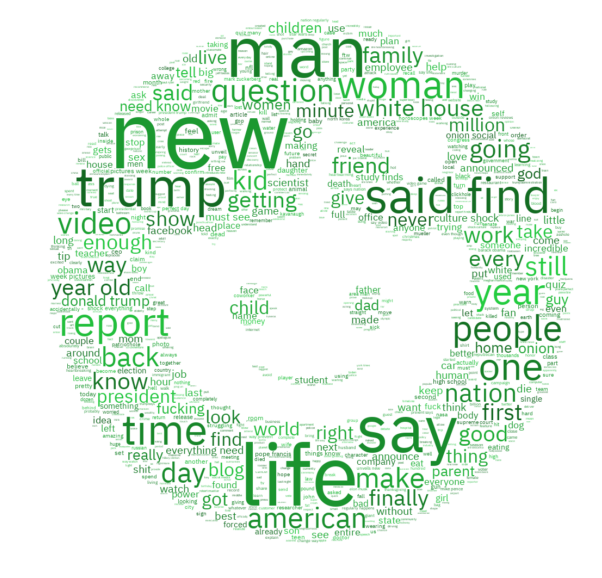

In [50]:
# Wordcloud for TheOnion
text = " ".join(title for title in df.loc[df['is_onion'] == 1, 'clean_title'])
gen_wordcloud(text, 'theonion', 'green')

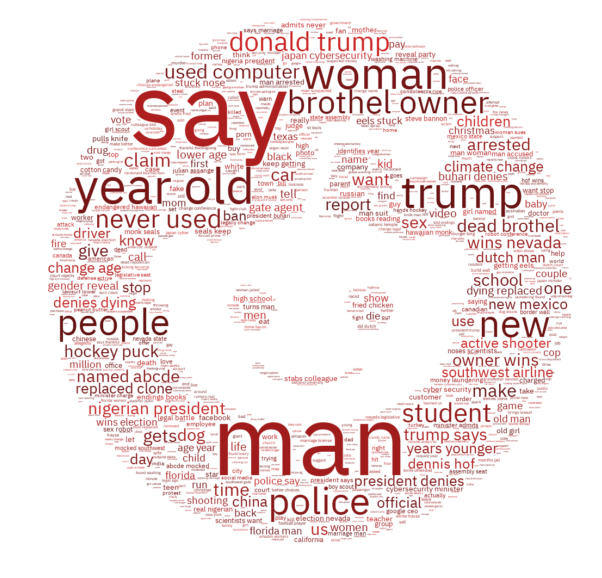

In [51]:
# Wordcloud for nottheonion
text = " ".join(title for title in df.loc[df['is_onion'] == 0, 'clean_title'])
gen_wordcloud(text, 'nottheonion', 'red')

### Conclusions

This model was able to predict with 86.82% accuracy whether an article was from r/TheOnion or r/nottheonion by title alone.

The words that were more likely to be from titles in r/TheOnion were quiz, nation, blog, incredible, and tips. The words that were more likely to be from titles in r/nottheonion were poop, arrested, sues, says, and cops.

Some misclassifications could result from a title containing a word the model associates with the other subreddit. A closer look shows that such submissions may have also been removed from the given subreddit due to not following submission guidelines. Many of the other misclassifications also turned out to be removed from their given subreddits for a variety of reasons. This suggests that filtering out submissions that were removed from subreddits could help improve model accuracy.

However, many submissions are also removed from both r/TheOnion and r/nottheonion due to duplication. Being able to see these submissions can provide insight into subscriber interest in an article. In the case of r/nottheonion, it can also provide insight into what articles subscribers think are appropriate for the subreddit, even if they are ultimately removed. In the case of r/TheOnion, repeated postings of a satirical article can be related to real-world events.

Next steps:

- Take a deeper dive into understanding the misclassified titles.
- Try filtering out submissions that were removed from the subreddits.
- Look at how repeated postings in r/TheOnion relate to real news.